In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import MaxNLocator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
df = pd.read_csv('data/drexler_complete_lyrics.csv', sep=';')
df.sample(10)

,id,lyrics,title,url,album,duplicated,year
117,1984556,Todo Cae Tarde o temprano A pesar de que por u...,Todo cae,https://genius.com/Jorge-drexler-todo-cae-lyrics,Bailar en la cueva,False,2014
43,1774973,Yo tengo pintada en la piel A lágrima de esta ...,Montevideo,https://genius.com/Jorge-drexler-montevideo-ly...,Llueve,False,1997
118,1973448,Mi anhelo no está Mi anhelo se fue detrás de t...,Universos paralelos,https://genius.com/Jorge-drexler-universos-par...,Bailar en la cueva,False,2014
101,1340909,La noche estaba cerrada Y las heridas abiertas...,Noctiluca,https://genius.com/Jorge-drexler-noctiluca-lyrics,Amar la trama,False,2010
74,897335,¿Dónde termina tu cuerpo y empieza el mío? A v...,Fusión,https://genius.com/Jorge-drexler-fusion-lyrics,Eco,False,2004
90,1472162,No hay nada tuyo que no quiera ver yo No tengo...,Quien Quiera Que Seas,https://genius.com/Jorge-drexler-quien-quiera-...,12 Segundos de Oscuridad,False,2006
126,3204462,Apenas nos pusimos en dos pies Comenzamos a m...,Movimiento,https://genius.com/Jorge-drexler-movimiento-ly...,Salvavidas de hielo,False,2017
11,1022208,Poco fue lo que quedó De su boca carmesí: Una ...,Edén,https://genius.com/Jorge-drexler-eden-lyrics,Radar,False,1994
111,2127140,Volviste como si nada Como si el tiempo no fue...,El triángulo de las bermudas,https://genius.com/Jorge-drexler-el-tringulo-d...,Bailar en la cueva,False,2014
39,1106526,Hay flores en el mar Hay flores en el mar En e...,Flores en el mar,https://genius.com/Jorge-drexler-flores-en-el-...,Llueve,False,1997


### Let's start with wordcount
##### Following: http://sigdelta.com/blog/text-analysis-in-pandas/

In [3]:
df['words'] = df.lyrics.str.strip().str.split('[\W_]+')

In [4]:
rows = list()
for row in df[['words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((word))

words = pd.DataFrame(rows, columns=['word'])
words.head()

,word
0,El
1,perfume
2,de
3,la
4,sal


In [5]:
#Remove empty rows and cases
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
words.head()

,word
0,el
1,perfume
2,de
3,la
4,sal


In [6]:
#Word count per song
counts = words\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts

,n_w
de,858
que,689
la,686
el,611
y,559
en,513
no,377
a,338
un,271
tu,269


## So, from this we get to know two important facts
 - Most used words in Jorge Drexler's songs are 'de', 'que', 'la', 'el' and 'y'
 - We need to exclude stopwords.

In [7]:
stopwords = stopwords.words('spanish')

In [8]:
for a_stopword in stopwords:
    if a_stopword in counts.index:
        counts = counts.drop(a_stopword)

In [9]:
counts.head(20)

,n_w
na,120
mar,108
tiempo,82
noche,67
luna,63
corazón,57
bailar,53
si,50
va,50
cada,50


### WTF is that 'na' topping the list?

In [10]:
songs = list()
for row in df[['title','words']].iterrows():
    r = row[1]
    if 'na' in r.words:
        songs.append(r.title)

songs

['Estalactitas']

### Now it's pretty obvious, just listen to the song.

In [11]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/YFBe7hLUPKo?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


In [12]:
counts = counts.drop('na')

In [13]:
counts.head(20)

,n_w
mar,108
tiempo,82
noche,67
luna,63
corazón,57
bailar,53
si,50
va,50
cada,50
dos,49


In [14]:
words_by_album = {}
words_by_year = {}
top_five_words = counts.head(5).index
for row in df[['album','words','year']].iterrows():
    r = row[1]
    if r.album == 'Others':
        continue
    if r.album not in words_by_album:
        words_by_album[r.album] = {
            top_five_words[0]: 0,
            top_five_words[1]: 0,
            top_five_words[2]: 0,
            top_five_words[3]: 0,
            top_five_words[4]: 0
        }
    if r.year not in words_by_year:
        words_by_year[r.year] = {
            top_five_words[0]: 0,
            top_five_words[1]: 0,
            top_five_words[2]: 0,
            top_five_words[3]: 0,
            top_five_words[4]: 0
        }
    for a_word in r.words:
        if a_word == top_five_words[0]:
            words_by_album[r.album][top_five_words[0]] += 1
            words_by_year[r.year][top_five_words[0]] += 1
        if a_word == top_five_words[1]:
            words_by_album[r.album][top_five_words[1]] += 1
            words_by_year[r.year][top_five_words[1]] += 1
        if a_word == top_five_words[2]:
            words_by_album[r.album][top_five_words[2]] += 1
            words_by_year[r.year][top_five_words[2]] += 1
        if a_word == top_five_words[3]:
            words_by_album[r.album][top_five_words[3]] += 1
            words_by_year[r.year][top_five_words[3]] += 1
        if a_word == top_five_words[4]:
            words_by_album[r.album][top_five_words[4]] += 1
            words_by_year[r.year][top_five_words[4]] += 1

In [15]:
top_five_words

Index(['mar', 'tiempo', 'noche', 'luna', 'corazón'], dtype='object')

In [16]:
ROWS = 4
COLS = 3
max_appearance = 0
for album in words_by_album:
    for word in words_by_album[album]:
        a_number = words_by_album[album][word]
        if a_number > max_appearance:
            max_appearance = a_number

albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 Segundos de Oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]
years_for_albums = [
    1992, 1994, 1996, 1997, 1999, 
    2001, 2004, 2006, 2010, 2014, 
    2017
]

colormap = {
    'mar': 'xkcd:royal blue',
    'tiempo': 'xkcd:mustard',
    'luna': 'grey',
    'noche': 'black',
    'corazón': 'xkcd:crimson' 
}

def autolabel(rects, x, y):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axes[x,y].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')


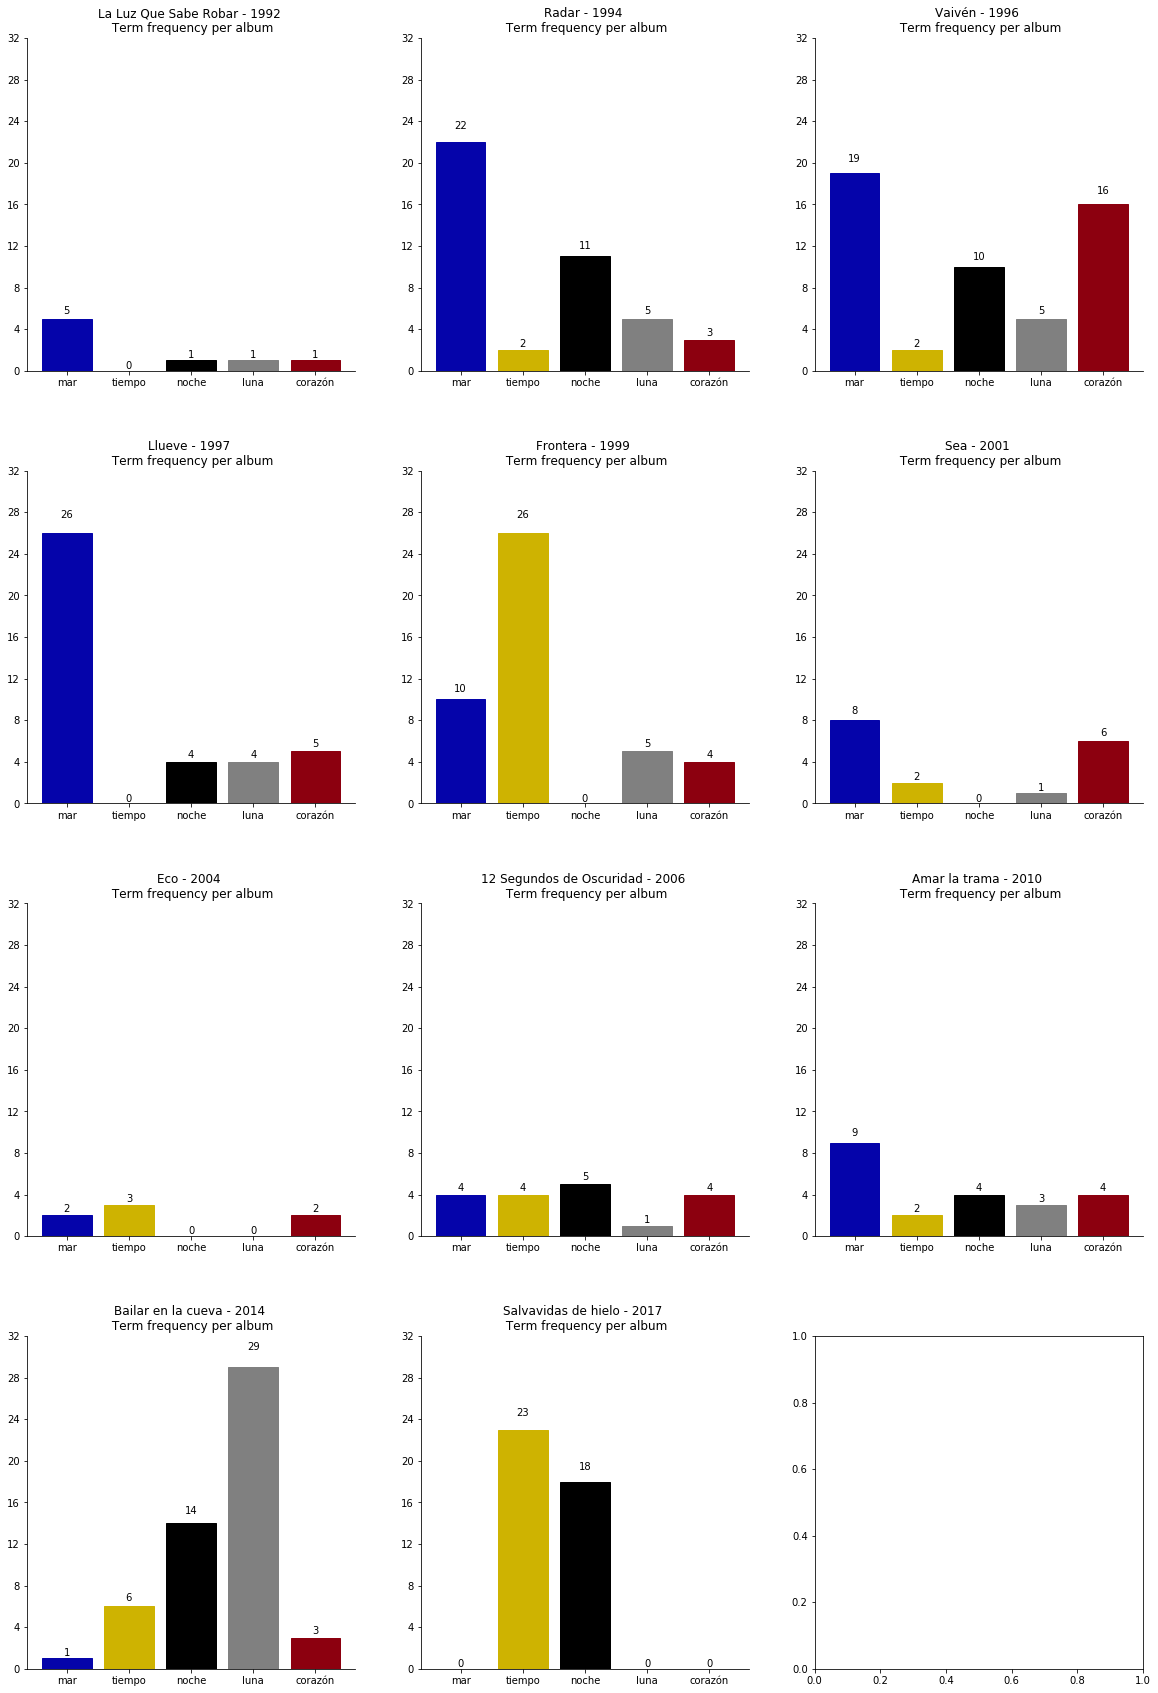

In [17]:
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))

for row in range(ROWS):
    for col in range(COLS):
        if not albums_ordered_by_year:
            break
        an_album_title = albums_ordered_by_year.pop(0)
        an_album_year = years_for_albums.pop(0)
        an_album = words_by_album[an_album_title]
        rects = axes[row, col].bar(range(len(an_album)), list(an_album.values()), align='center')
        axes[row, col].set_xticks(range(len(an_album)))
        axes[row, col].set_xticklabels(list(an_album.keys()))
        axes[row, col].yaxis.set_major_locator(MaxNLocator(integer=True))
        axes[row, col].set_ylim([0,max_appearance + 3])
        axes[row, col].set_title("%s - %d \n Term frequency per album" % (an_album_title, an_album_year))
        axes[row, col].spines['right'].set_visible(False)
        axes[row, col].spines['top'].set_visible(False)
        rects[0].set_color('xkcd:royal blue')
        rects[1].set_color('xkcd:mustard')
        rects[2].set_color('black')
        rects[3].set_color('grey')
        rects[4].set_color('xkcd:crimson')
        autolabel(rects, row, col)

plt.subplots_adjust(hspace = 0.3)
plt.show()

## Interesting insight:
    - He loved talking about the sea ('mar') in the 90's but grew bored as time passed by.
    - After a time in his albums where he doesn't revisit his favorite terms a lot, comes back to monothematic stuff.
    - Bailar en la cueva is super focused on the moon ('luna') and the night ('noche').
    - Salvavidas de hielo is about the pass of time ('tiempo'), a trend which he recovered from Frontera, and again, the night ('noche').

In [18]:
words_by_year = pd.DataFrame(words_by_year).transpose()

In [19]:
values_for_y_ticks = []
for a_word in words_by_year.columns:
    values_for_y_ticks.extend(words_by_year[a_word].unique())
values_for_y_ticks = list(set(values_for_y_ticks))

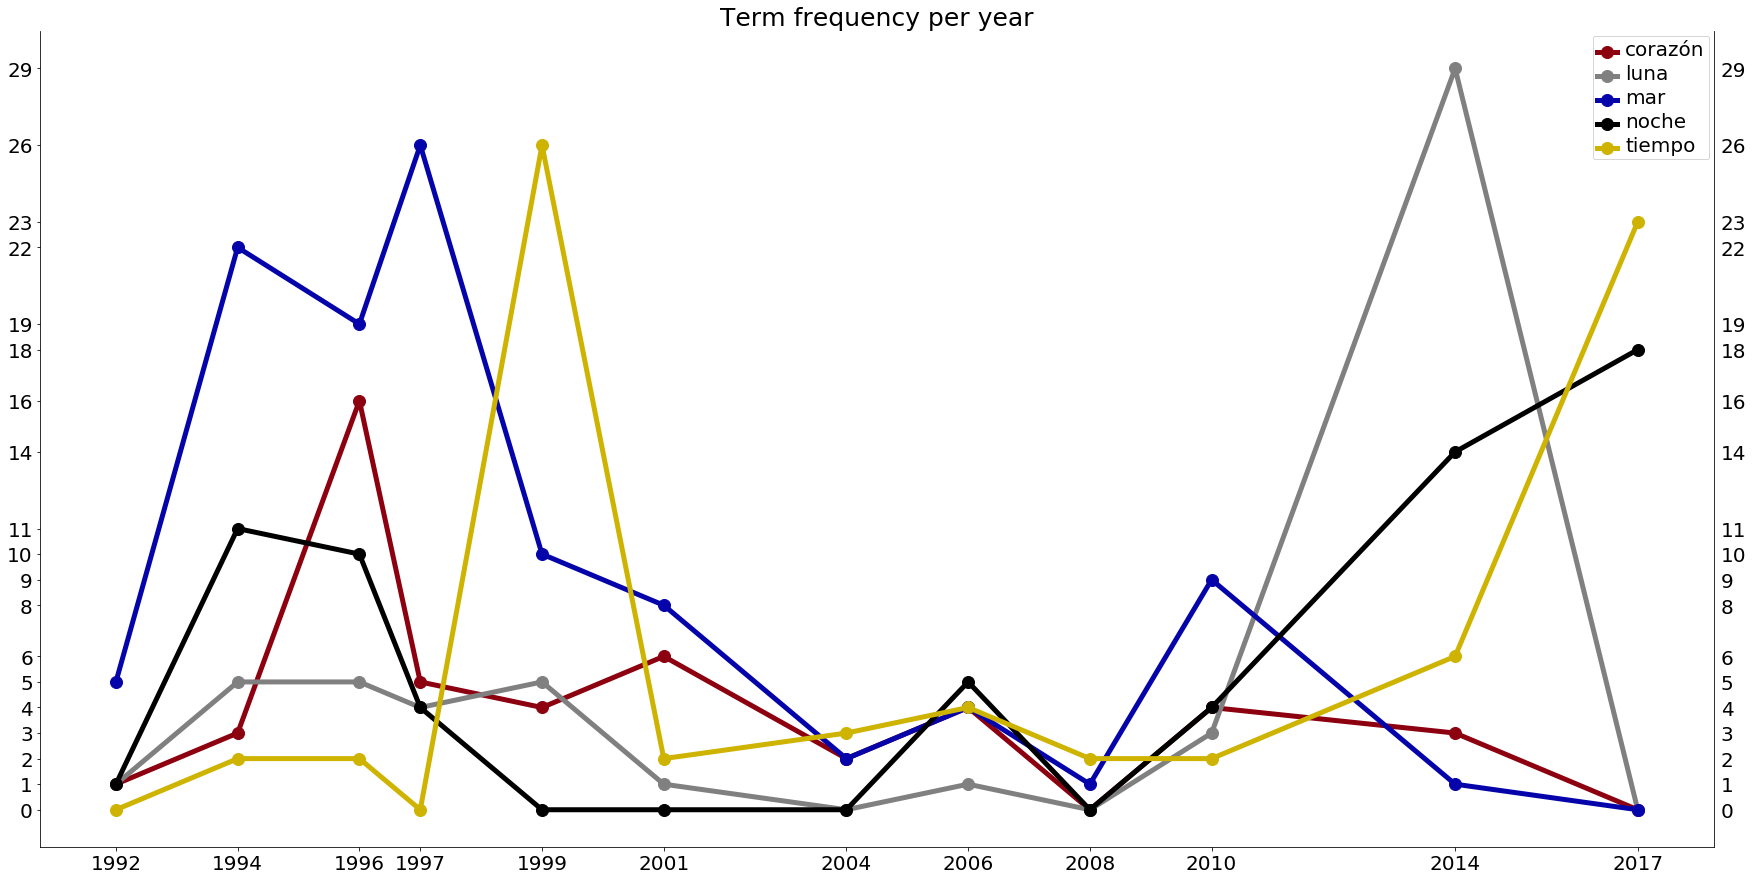

In [20]:
fig, ax = plt.subplots(figsize=(30,15))
for top_word in list(words_by_year.columns):
    ax.plot(
        words_by_year.index, 
        words_by_year[top_word], 
        '-', 
        color=colormap[top_word], 
        linewidth=5, 
        marker='o',
        markersize=12
    )
leg = plt.legend()
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(5)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize(20)
plt.xticks(words_by_year.index)
plt.yticks(values_for_y_ticks)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Term frequency per year", fontdict={'fontsize': 25})
plt.show()

## Lets polish this

Future lines of work:

- http://www.everydayanalytics.ca/2013/06/radiohead-lyrics-data-visualization-and-content-analysis.html
- https://www.promptcloud.com/blog/data-visualization-text-mining-taylor-swift-song-lyrics
- https://medium.com/@krisshaffer/exploring-musical-data-with-r-an-introduction-to-computational-music-analysis-2216d061fed6 chords through spotify api?
- 

New try

In [21]:
df = pd.read_csv("data/drexler_final.csv", sep=';',index_col=0)

In [22]:
df.head()

,track_number,name,album,year,duplicated,duration_ms,duration_s,acousticness,danceability,energy,key,tempo,time_signature,valence,mode,lyrics
index,,,,,,,,,,,,,,,,
0,1,Movimiento,Salvavidas de hielo,2017,False,231653,23.165.333,0.900,0.784,0.457,2.0,125.021,4.0,0.546,1.0,Apenas nos pusimos en dos pies Comenzamos a mi...
1,2,Telefonía,Salvavidas de hielo,2017,False,184963,18.496.354,0.829,0.915,0.592,6.0,126.060,4.0,0.841,0.0,Que viva la telefonía En todas sus variantes P...
2,3,Silencio,Salvavidas de hielo,2017,False,207986,20.798.667,0.263,0.887,0.568,4.0,127.923,4.0,0.127,0.0,Todo el mundo intentando venderte algo Intenta...
3,4,Pongamos que hablo de Martínez,Salvavidas de hielo,2017,False,182453,18.245.333,0.893,0.849,0.458,9.0,119.950,4.0,0.461,1.0,"Fuimos cerrando, uno a uno cuatro bares Montev..."
4,5,Estalactitas,Salvavidas de hielo,2017,False,261066,26.106.667,0.797,0.772,0.630,0.0,136.019,4.0,0.909,1.0,El tiempo era entonces dinamita Vivíamos colga...


In [23]:
df['duration_s'] = df['duration_ms'] * 0.001

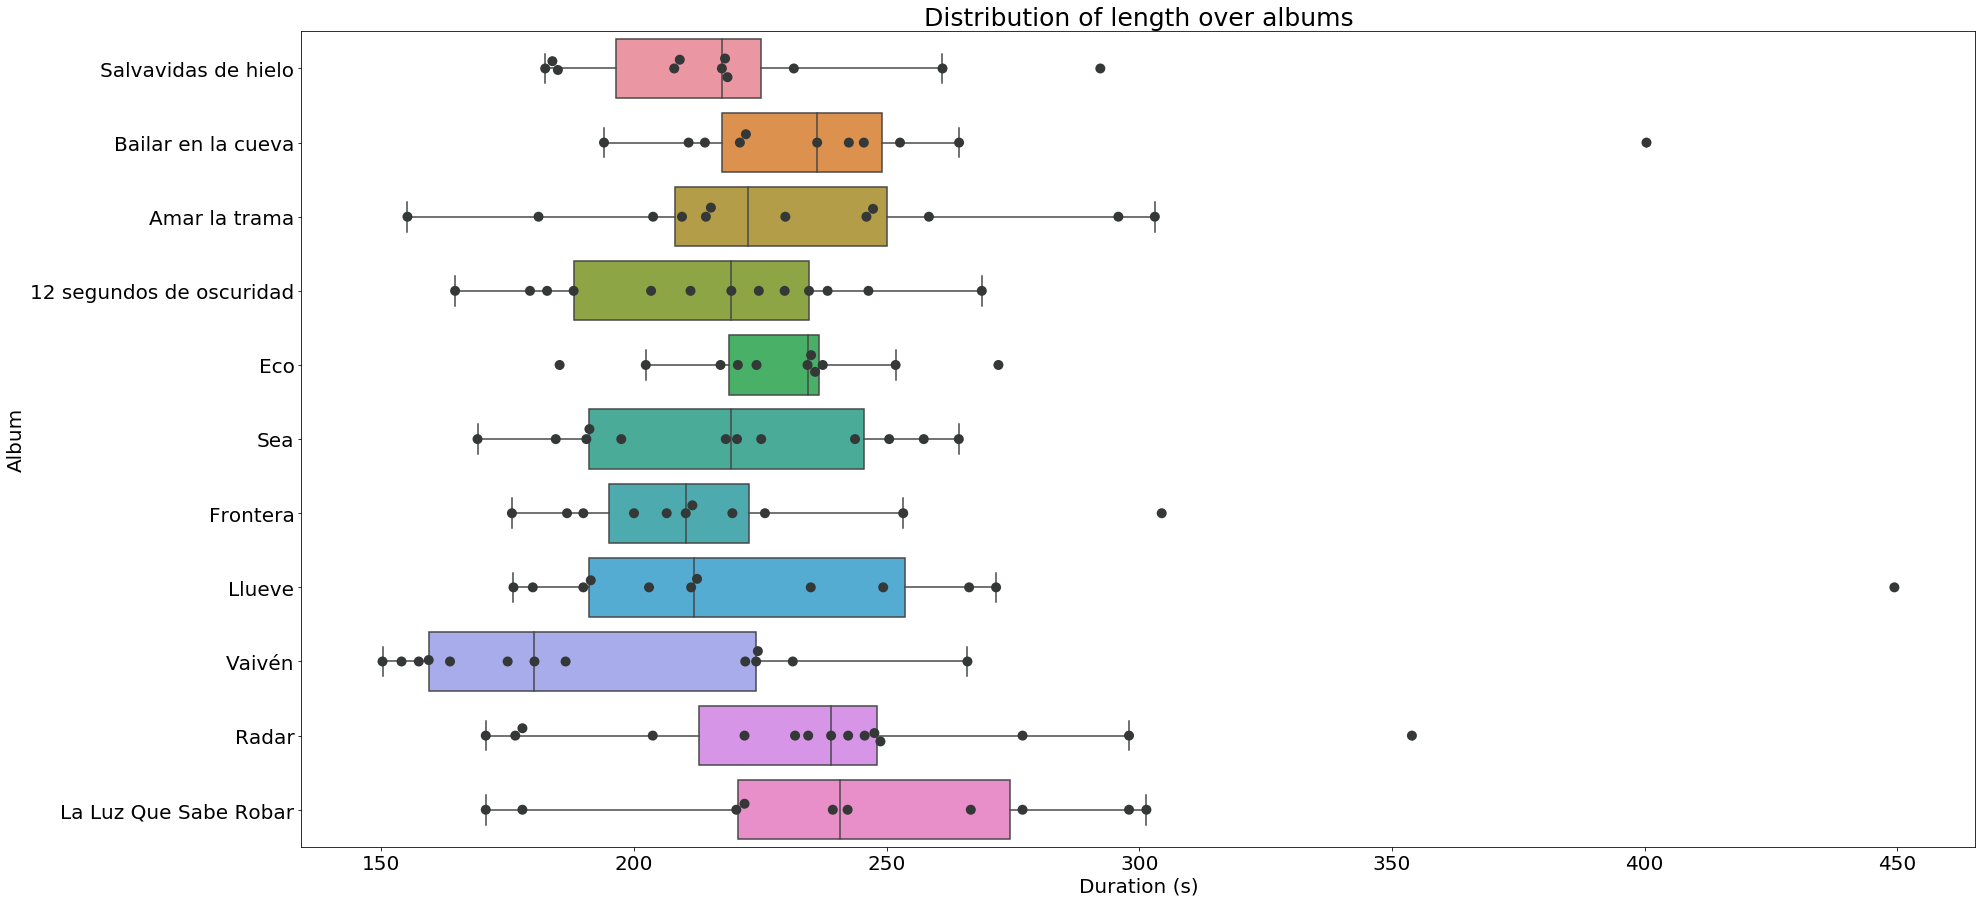

In [24]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="duration_s", y="album", data=df, orient='h')
ax = sns.swarmplot(x="duration_s", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Duration (s)', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of length over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

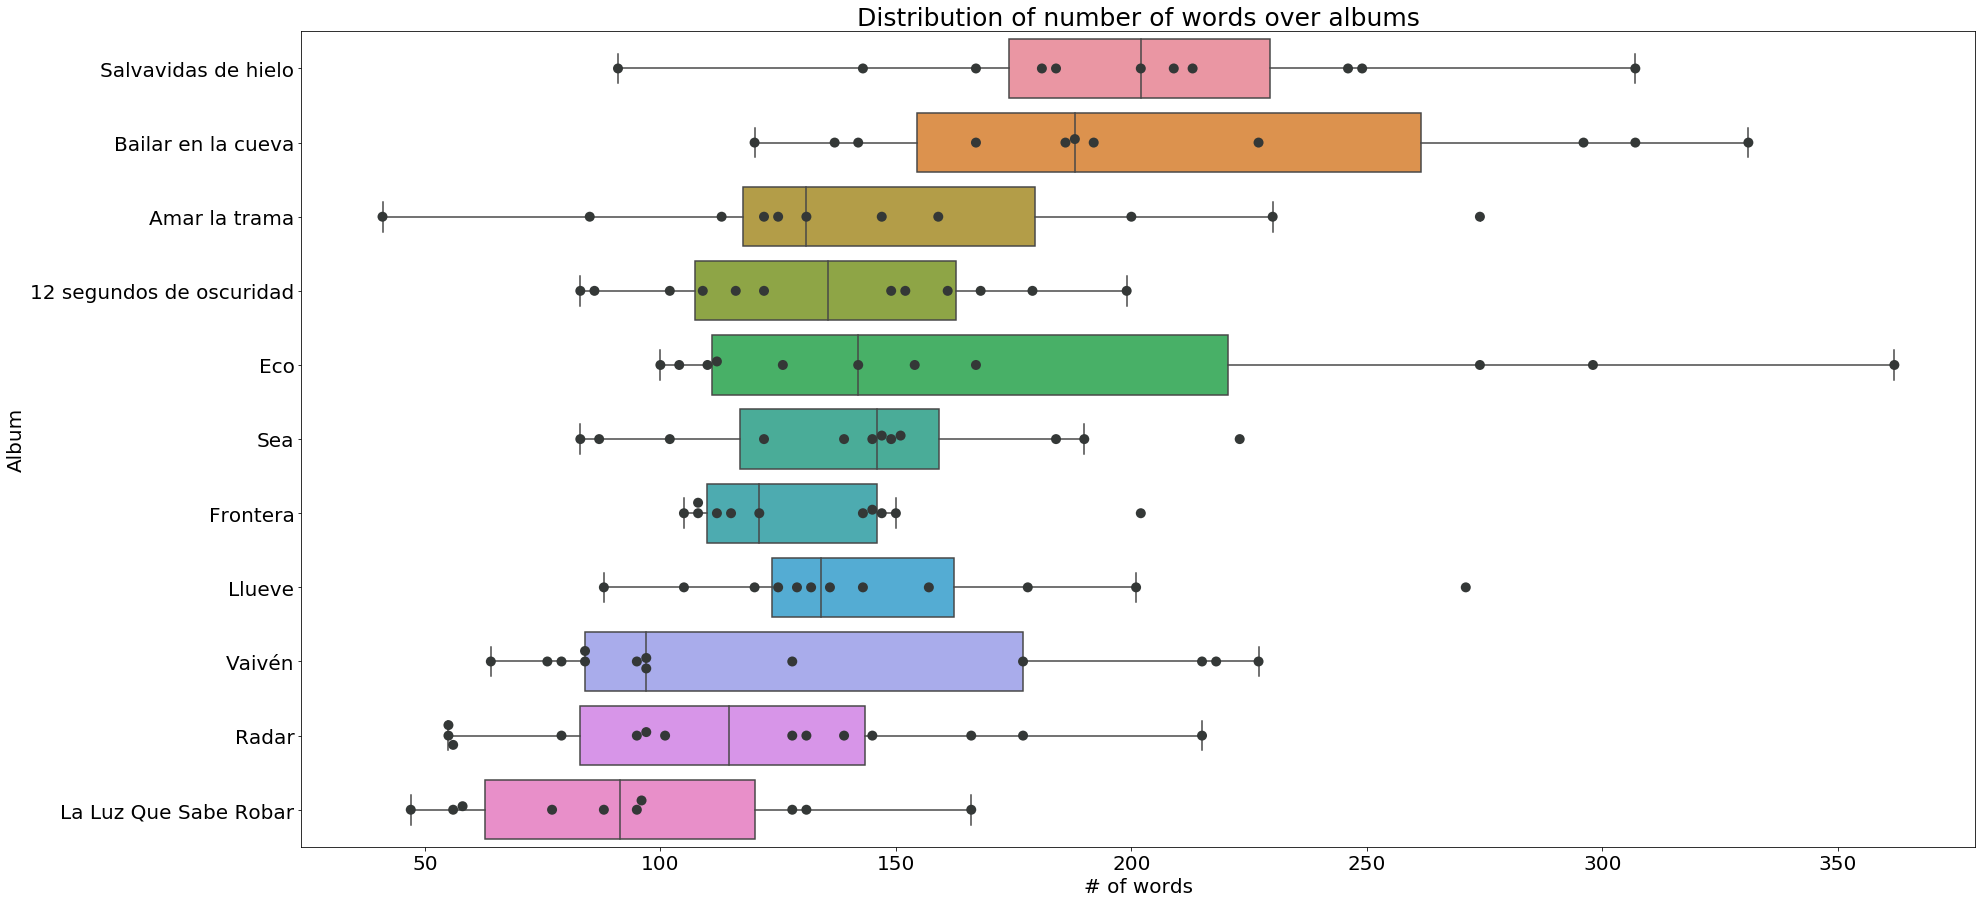

In [25]:
amount_of_words = df.lyrics.str.split().str.len()


fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x=amount_of_words, y="album", data=df, orient='h')
ax = sns.swarmplot(x=amount_of_words, y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('# of words', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of number of words over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

In [34]:
stopset = set(stopwords)
df['tokens'] = pd.Series(dtype=object)

In [35]:
for index, row in df.iterrows():
    try:
        tokens = word_tokenize(row['lyrics'])
        tokens_wo_stopwords = [word for word in tokens if not word in stopset]
        df.at[index, 'tokens'] = tokens_wo_stopwords
        df.at[index, 'le_d'] = ( len(tokens_wo_stopwords) / len(tokens) ) * 100
        df.at[index, 'ly_d'] = len(tokens) / row['duration_s']
        df.at[index, 'n_words'] = len(tokens)
        df.at[index, 'n_words_no_rep'] = len(list(set(tokens)))
    except: # songs without lyrics throw exceptions, i'm lazy
        continue

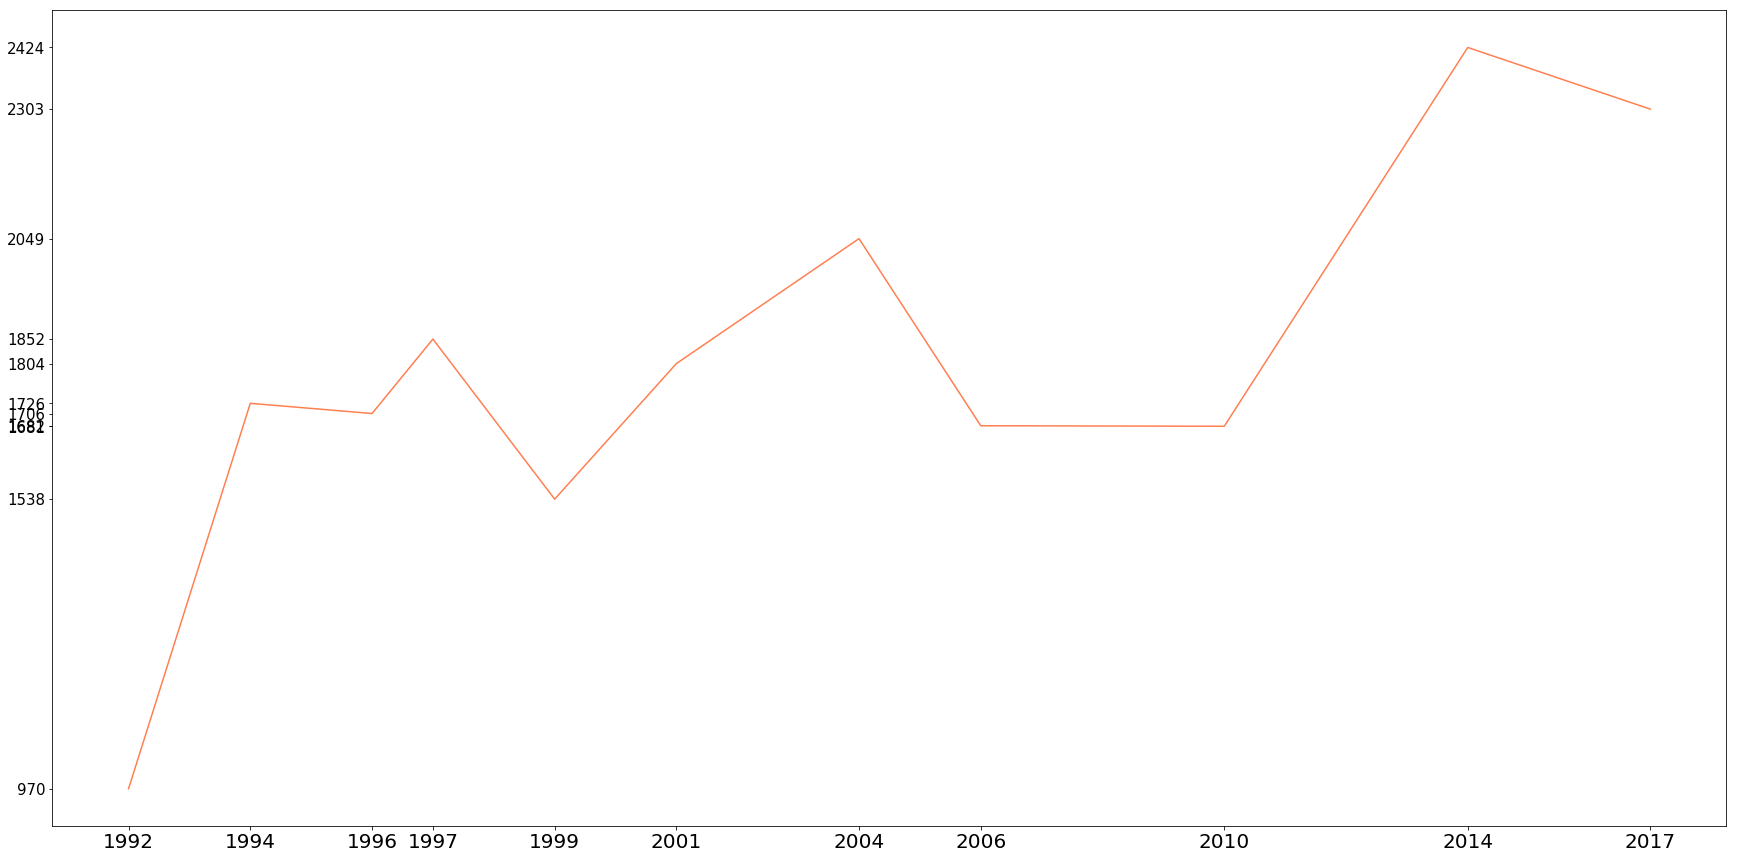

In [62]:
fig, ax = plt.subplots(figsize=(30,15))
n_words_by_album = df.groupby(["year"])['n_words'].sum()
ax = sns.lineplot(data=n_words_by_album, color="coral", legend=False, size=300)
plt.xticks(n_words_by_album.index)
plt.yticks(n_words_by_album)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.plot();

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="le_d", y="album", data=df, orient='h')
ax = sns.swarmplot(x="le_d", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Lexical density', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of lexical density over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

In [ ]:
df['le_d'] = df['le_d'].fillna(0)

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.distplot(df[df['le_d'] > 0]['le_d'], bins=30)
plt.xlabel('Lexical density', fontsize=20)
plt.title('Distribution of lexical density', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();


In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="ly_d", y="album", data=df, orient='h')
ax = sns.swarmplot(x="ly_d", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Lyrical density', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of lyrical density over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

In [ ]:
df['ly_d'] = df['ly_d'].fillna(0)

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.distplot(df[df['ly_d'] > 0]['ly_d'], bins=30)
plt.xlabel('Lyrical density', fontsize=20)
plt.title('Distribution of Lyrical density', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();


LE VS LY?


In [ ]:
songs_with_more_words = df.sort_values("n_words", ascending=False)[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="n_words", y="name", data=songs_with_more_words)
plt.ylabel("")
plt.xlabel('# of words', fontsize=20)
plt.title('Top 10 songs with more words', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 8  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

In [ ]:
songs_with_less_words = df.sort_values("n_words")[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="n_words", y="name", data=songs_with_less_words)
plt.ylabel("")
plt.xlabel('# of words', fontsize=20)
plt.title('Top 10 songs with less words', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1.5  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();